# Sea level budget

In [46]:
import sys
sys.path.append('../code')
import importlib
from time import gmtime, strftime

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import xarray as xr
import IPython.display
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
#import netCDF4

import SeaLevelContrib as slc

/var/folders/4x/jddrv9056c3bmvydrhcmv4gw0000gn/T/ipykernel_5024/3225428669.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [191]:
importlib.reload(slc)

<module 'SeaLevelContrib' from '/Users/dewilebars/Projects/SLBudget/notebooks/../code/SeaLevelContrib.py'>

In [192]:
path_outputs = '../outputs/'

### Namelist

In [208]:
# Pick a region name (see choices bellow): 
tg_sel = 'ZSM' # Tide gauge selection, see options in the next cell
opt_sl = 'tide_gauge' # Use sea level observations from 'tide_gauge' or from 
                      #satellite altimetry ('altimetry')
opt_steric = ['IAP','EBB',1000, 3] 
                # [0]: Poduct: 'EN4_21', 'EN4_22' and 'IAP' available so far
                # [1]: Region on which to average the steric effect: 
                # ENS: Extended North Sea, 
                # EBB: Extended Bay of Biscay 
                # NWS: Norwegian Sea
                # [2]: Depth of integration in meters
                # [3]: Number of years to use in smoothing window
opt_glaciers = 'fred20' # fred20
                            # marzeion15 for Marzeion et al. 2015
                            # zemp19 for Zemp et al. 2019
opt_antarctica = 'fred20' # rignot19, imbie18, fred20
opt_greenland = 'fred20' # mouginot19, fred20
                             # IMBIE is used in Greenland.ipynb but not yet implemented here
opt_tws = 'fred20' # humphrey19 for Humphrey and Gudmundson 2019
                       # fred20 for Frederikse et al. 2020
#!!! Nodal cycle only included for regression method, not yet for dynamical model
opt_wind_ibe = ['regression','ERA5'] # Method 'regression' or 'dynamical_model' 
                          # 'NCEP1': Regression to NCEP1 (1948 to now)
                          # 'ERA5' : Regression to ERA5 (1979 to now)
                          # 'WAQUA' : Use the barotropic ocean model WAQUA
                          # 'GTSM': Use the barotropic ocean model GTSM
opt_nodal = 'potential' # 'potential' or 'regression', 'regression' only available 
                         #if opt_wind_ibe[0] is also 'regression'
global_steric = 'fred20' # None for no splitting between global and local
                     # 'levitus' or 'fred20' otherwise
INFO = True # Additional info on the computations

In [209]:
reg_dict = {'ZSM' : [20, 22, 23, 24, 25, 32], # Zeespiegelmonitor (Dutch coast)
            # North Sea Frederikse et al. 2016
            'NS_Fred16': [20, 32, 236, 7, 80, 89, 302, 47, 830, 361, 95, 754],
            'NS_waqua': [20, 32, 236, 7, 80, 47, 361, 95, 754],
            'Newlyn': [202], 
            'Brest': [1], 
            'Vlissingen': [20]}

tg_id = reg_dict[tg_sel]
tg_id

[20, 22, 23, 24, 25, 32]

### Budget

In [210]:
# Check the tide gauge data
tg_df = slc.tide_gauge_obs(tg_id, interp=True)
tg_df #.loc[1960:1965]

,20,22,23,24,25,32,Average
time,,,,,,,
1862,-2.450625,NaN,NaN,NaN,NaN,NaN,-2.450625
1863,-4.350625,NaN,NaN,NaN,NaN,NaN,-4.350625
1864,-7.850625,-25.753165,NaN,NaN,NaN,NaN,-16.801895
1865,-4.950625,-24.653165,-18.098089,-15.224204,-22.407643,NaN,-17.066745
1866,2.249375,-19.453165,-4.698089,-5.924204,-8.007643,NaN,-7.166745
...,...,...,...,...,...,...,...
2017,16.349375,20.646835,15.501911,21.975796,17.292357,16.918,18.114046
2018,11.849375,14.846835,8.801911,12.275796,7.092357,10.118,10.830712
2019,16.849375,21.146835,17.001911,21.275796,16.392357,14.218,17.814046


In [211]:
slmean_df = slc.budget_at_tg(INFO, tg_id, opt_sl, opt_steric, opt_glaciers, 
                             opt_antarctica, opt_greenland, opt_tws, opt_wind_ibe, 
                             opt_nodal, global_steric, True)


Working on tide gauge id: 20
found point 51.5 3.5
Working on tide gauge id: 22
found point 52.0 4.0
Working on tide gauge id: 23
found point 53.0 4.75
Working on tide gauge id: 24
found point 53.25 7.0
Working on tide gauge id: 25
found point 53.25 5.5
Working on tide gauge id: 32
found point 52.5 4.5


In [212]:
#slmean_df = slmean_df.loc[1958:2014] # Select date to fit Fred16 study
#slmean_df = slmean_df.loc[1993:]

In [213]:
display(slmean_df.iloc[:5])
display(slmean_df.iloc[-5:])

,Total,LocSteric,GloSteric,GIA,Glaciers,Antarctica,Greenland,TWS,Nodal,Wind,Pressure,Obs
time,,,,,,,,,,,,
1950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.580712
1951,-5.058634,-3.154764,0.097124,0.036833,0.054167,0.004167,0.006667,0.360000,0.007106,-2.846104,0.376170,1.047379
1952,0.170836,0.961062,0.176444,0.073667,0.115833,0.010000,0.011667,0.333333,-0.046784,-1.360111,-0.104274,3.480712
1953,-5.008433,-2.191099,0.177486,0.110500,0.186667,0.014167,0.017500,0.296667,-0.155587,-1.842369,-1.622364,-0.419288
1954,0.949203,-2.999954,0.193522,0.147333,0.242500,0.019167,0.020000,0.148333,-0.307016,3.325759,0.159559,2.347379


,Total,LocSteric,GloSteric,GIA,Glaciers,Antarctica,Greenland,TWS,Nodal,Wind,Pressure,Obs
time,,,,,,,,,,,,
2017,11.107861,0.837110,4.838131,2.467833,2.657500,0.850833,0.269167,-0.684167,-1.030123,1.595332,-0.693756,18.114046
2018,4.801805,0.082601,4.889651,2.504667,2.677500,0.959167,0.276667,-0.811667,-0.928142,-4.222679,-0.625959,10.830712
2019,9.601763,0.424601,5.082026,2.541500,2.725333,0.990444,0.286778,-0.516500,-0.781557,-0.989294,-0.161569,17.814046
2020,13.069384,1.347332,5.208009,2.578333,2.774045,1.037283,0.296283,-0.514621,-0.606920,1.330054,-0.380414,18.364046
2021,6.878599,-0.827176,5.333992,2.615167,2.822758,1.084121,0.305788,-0.512742,-0.423950,-2.724497,-0.794860,16.247379


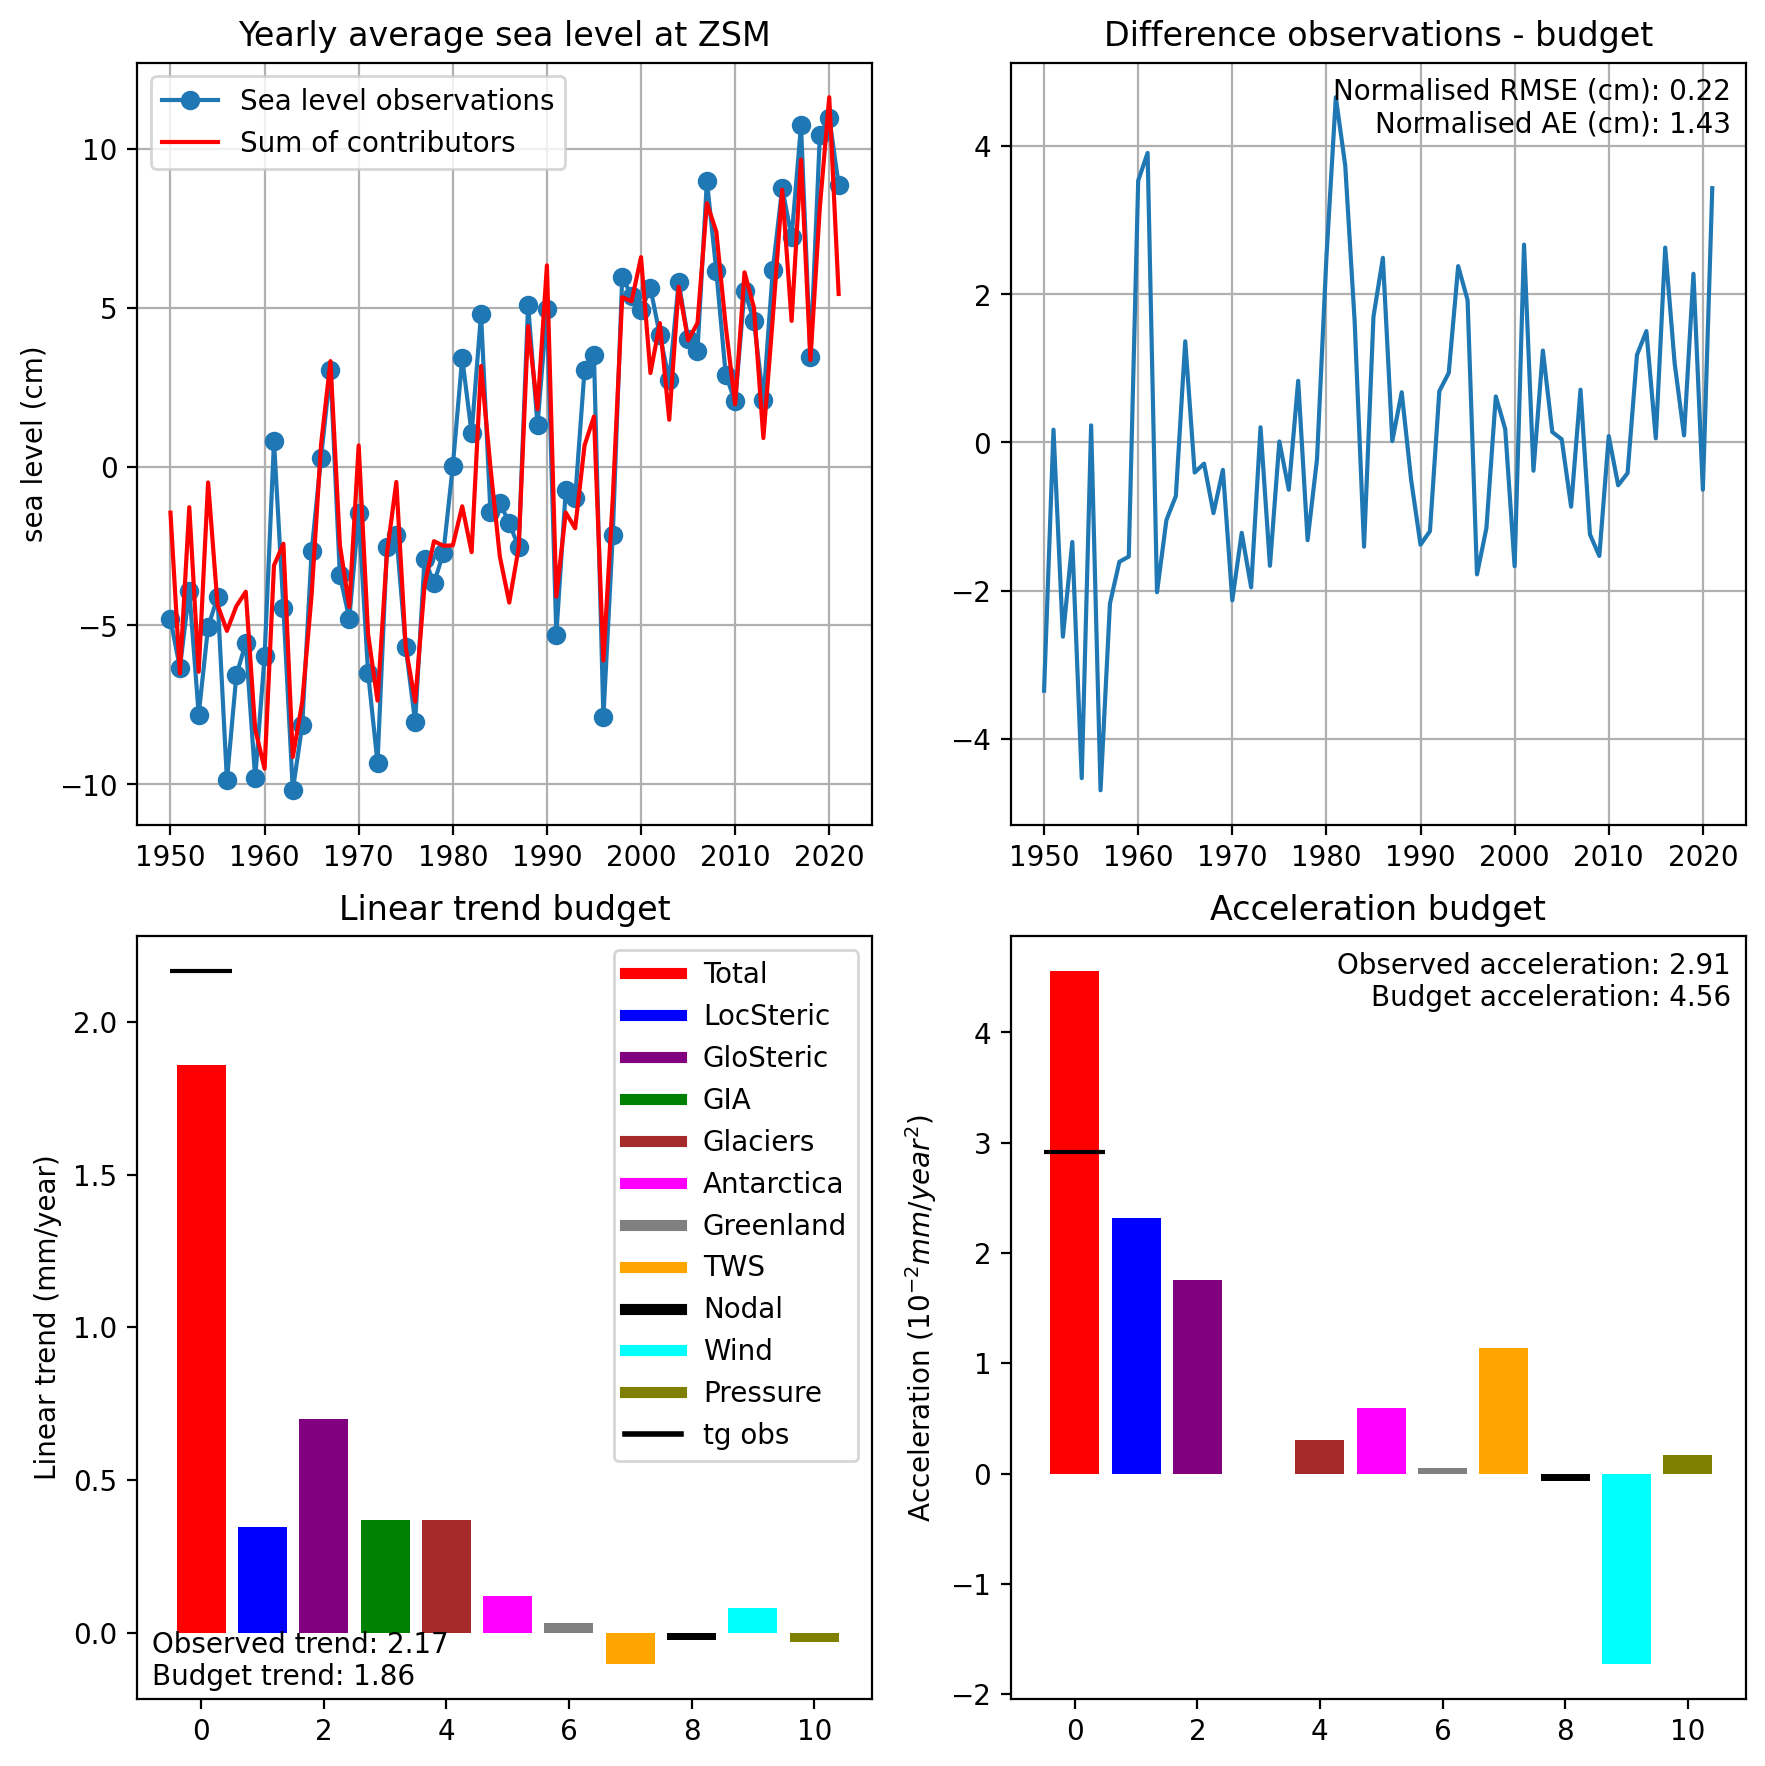

In [214]:
fig, ax = slc.plot_budget(tg_sel, slmean_df)

<AxesSubplot: xlabel='time'>

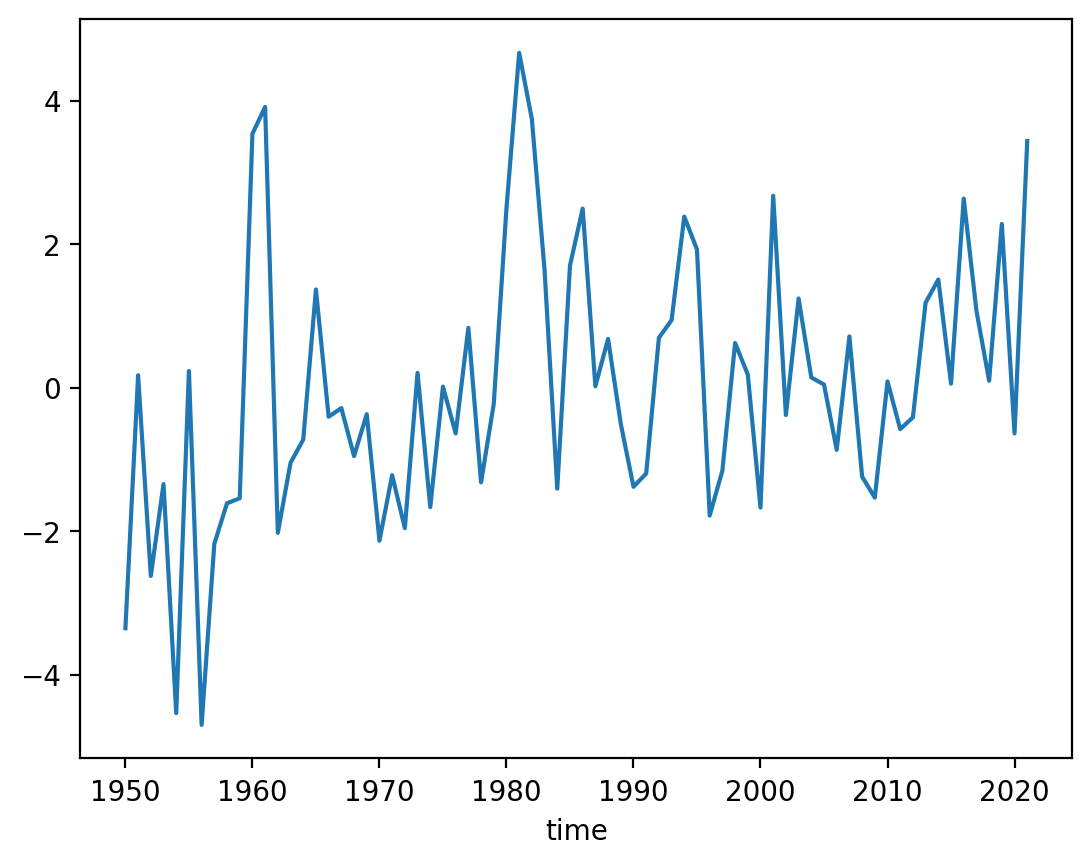

In [215]:
diff = slmean_df['Obs']-slmean_df['Total']
diff = diff-diff.mean()
diff.plot()

<AxesSubplot: xlabel='time'>

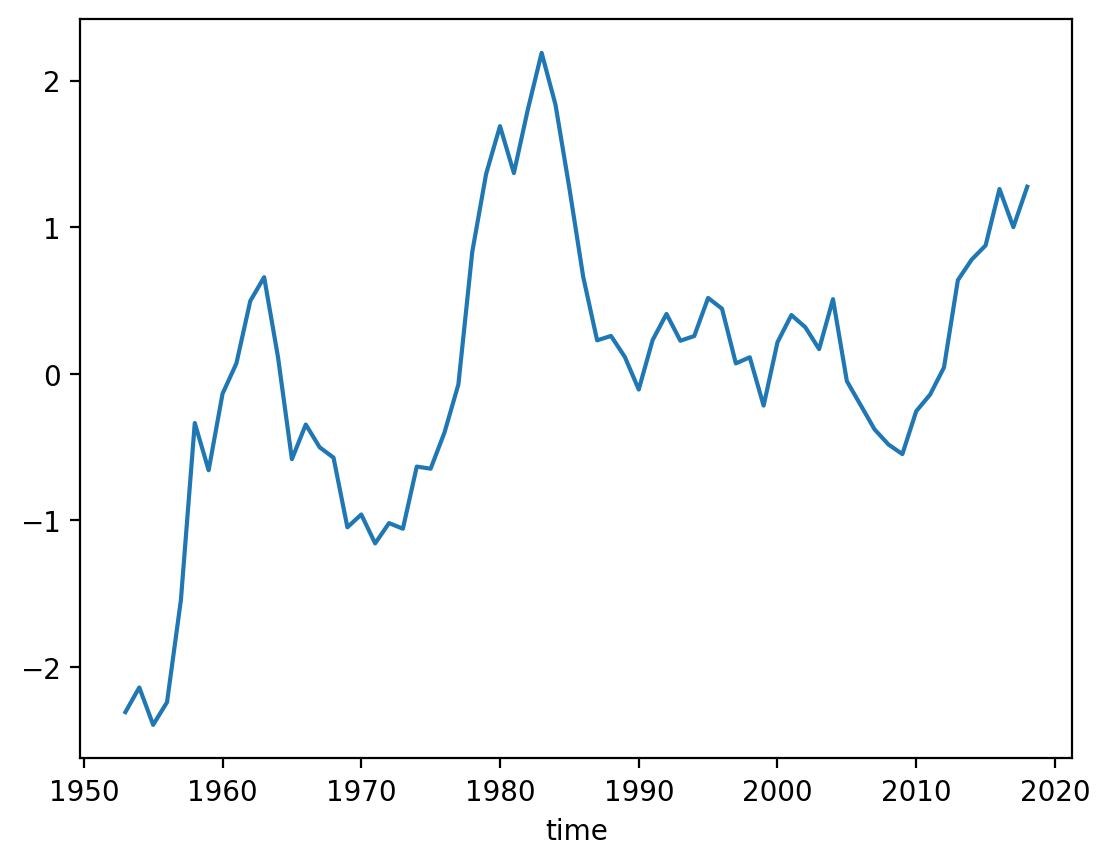

In [216]:
diff_ra3 = diff.rolling(7,center=True).mean()
diff_ra3.plot()

In [217]:
budget_name = (f'slbudget_{strftime("%Y_%m_%d", gmtime())}_{tg_sel}_{opt_sl}_'+
               f'{slmean_df.index[0]}_{slmean_df.index[-1]}_{opt_wind_ibe[1]}_'+
               f'Steric{opt_steric[0]}_{opt_steric[2]}m')

# Write out a budget csv file
slmean_df.to_csv(path_outputs+budget_name+'.csv')

# Write out the figure
fig.savefig(path_outputs+budget_name+'.pdf', bbox_inches='tight') #pad_inches=2

# Write budget info to a text file
text_out = ('Budget information: \n'
            'Tide gauge selection: '+tg_sel+' \n'
            'Sea level data used: '+opt_sl+' \n'
            'Corresponding to ids: '+str(tg_id)+' \n'
            'Period: '+str(slmean_df.index[0])+'-'+str(slmean_df.index[-1])+' \n'
            'Steric contribution: '+str(opt_steric)+' \n'
            'Global steric: '+global_steric+' \n'
            'Glaciers: '+opt_glaciers+' \n'
            'Antarctica:'+opt_antarctica+' \n'
            'Greenland: '+opt_greenland+' \n'
            'Terrestrial water storage: '+opt_tws+' \n'
            'Wind and inverse barometer effect: '+str(opt_wind_ibe)+' \n'
           )

file = open(path_outputs+budget_name+'.txt','w') 
file.write(text_out)
file.close()

# Alternative for better tracability but less lisibility:
# Generate a unique number that describes the budget, number the options and give an order:21324

### Some remarks

Comment on the choice of steric expansion location:
It seems that using the Bay of Biscay reduces the eror compared to extended North Sea.
On the other hand Norwegian Sea increases it.

Computing the wind, nodal and pressure effects (linear fit) after removing the trend from the reconstruction improves the fit compared to computing the fit using a linear trend.

Using the extended Bay of Biscay area, mostly solves the trend problem but it introduces higher rms (0.27) and ae (1.30).

The same conclusion applies to stopping the integration of steric effect at 60N instead of the standard 69N. This is because steric trend in the region 60-69 is smaller than further South (see the Steric notebook). What is the most relevent for the North Sea?

Using sea level from WAQUA forced by ERA-interim increases the rmse (0.26) and ae (1.35) compared to linear regressions to ERA5 or NCEP1 reanalysis. This might be because of sea level variations external to the domain entering the domain.

One possible difference between KNMI projections and Deltares zsm is the vertical land motion: GIA from ICE6G provides 0.36mm/y for the Dutch tide gauges while 0.45 was used in the ZSM. That is still not much: 2 mm in 20 years.

The computation of acceleration is very sensitive to the period used to compute it even for the steric effect. Also it seems very difficult to get right. For example at the Brest tide gauge, observations show a deceleration while the budget shows an acceleration.
This points toward the need to consider longer time periods to study the acceleration.

Even in the period 1950-2017 the acceleration is difficult to get right. For the Dutch coast the budget gives twice larger values than the tide gauge observations. For that period it seems that for Newlyn, Brest and Dutch coast the trend is underestimated and the acceleration is overestimated.

Acceleration for the Dutch coast is very sensitive to the wind and steric effects: check starting point in 1950 compared to 1958 -> Also check over the ERA5 period

__12/2021__

Between 1950 and 1960 IAP is a lot better than EN4. EN4 has a strange behaviour there that is not backed up by tide gauge data.
Integrating steric sea level up to 1000m improves North Sea compared to 2000m. But not the Dutch coast. Probably because of underestimatd GIA?

Unfortunately the choice of region and product used for the steric sea level matters.

Large error using EBB in 1961 when sea level rose but the budget doesn't see it.

### Tests

In [152]:
en421_df = slc.StericSL(0, max_depth=opt_steric[2], mask_name=opt_steric[1], 
                         data_source="EN4_21", window=0)
en421_df.rename(columns={"Steric":"EN4_21"}, inplace=True)

en422_df = slc.StericSL(0, max_depth=opt_steric[2], mask_name=opt_steric[1], 
                         data_source="EN4_22", window=0)
en422_df.rename(columns={"Steric":"EN4_22"}, inplace=True)

EN4 = en421_df.join(en422_df, how='outer')

<AxesSubplot: xlabel='time'>

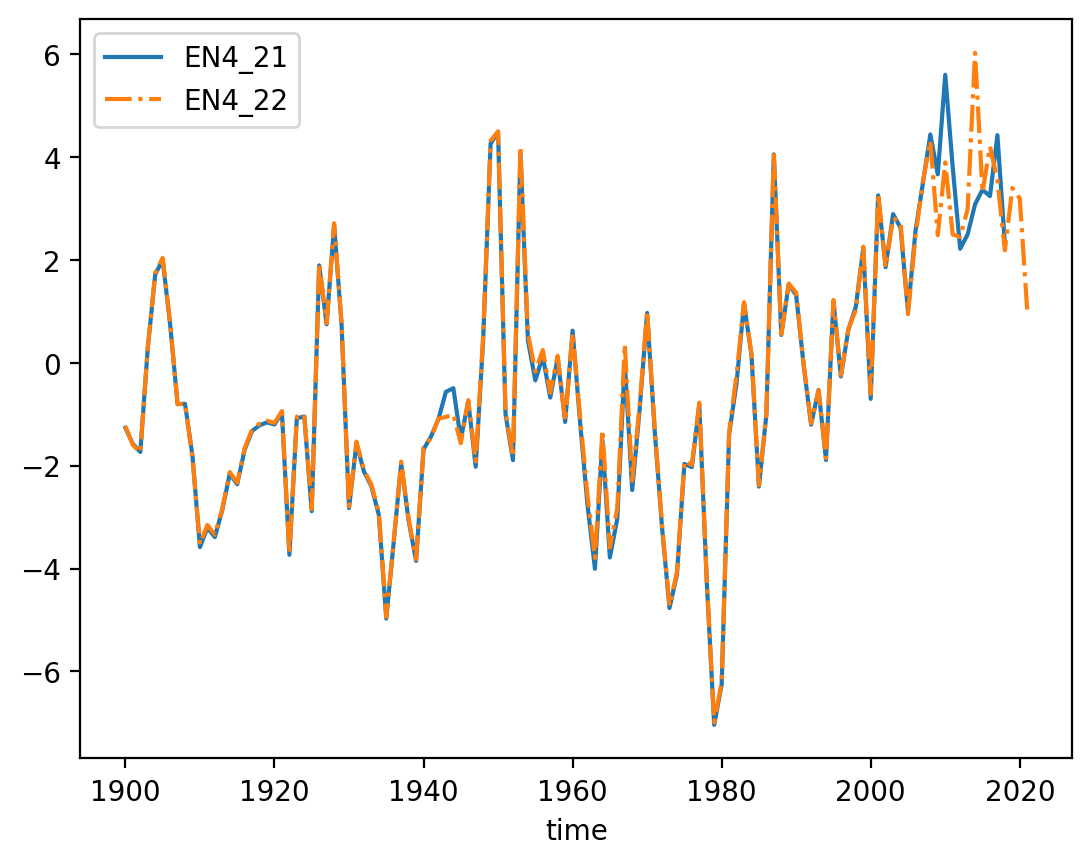

In [153]:
#en421_df.plot()
#en422_df.plot()

EN4.plot(style=['-', '-.'])

In [84]:
glac_ts_df = slc.contrib_frederikse2020([22], 'glac', extrap=True)

In [147]:
glac_ts_df

,Glaciers
time,
1900,-5.510000
1901,-5.435000
1902,-5.365000
1903,-5.310000
1904,-5.265000
...,...
2017,0.405000
2018,0.425000
2019,0.473333


In [148]:
glac_ts_df['Glaciers'] = 0

glac_ts_df

,Glaciers
time,
1900,0
1901,0
1902,0
1903,0
1904,0
...,...
2017,0
2018,0
2019,0


<AxesSubplot: xlabel='time'>

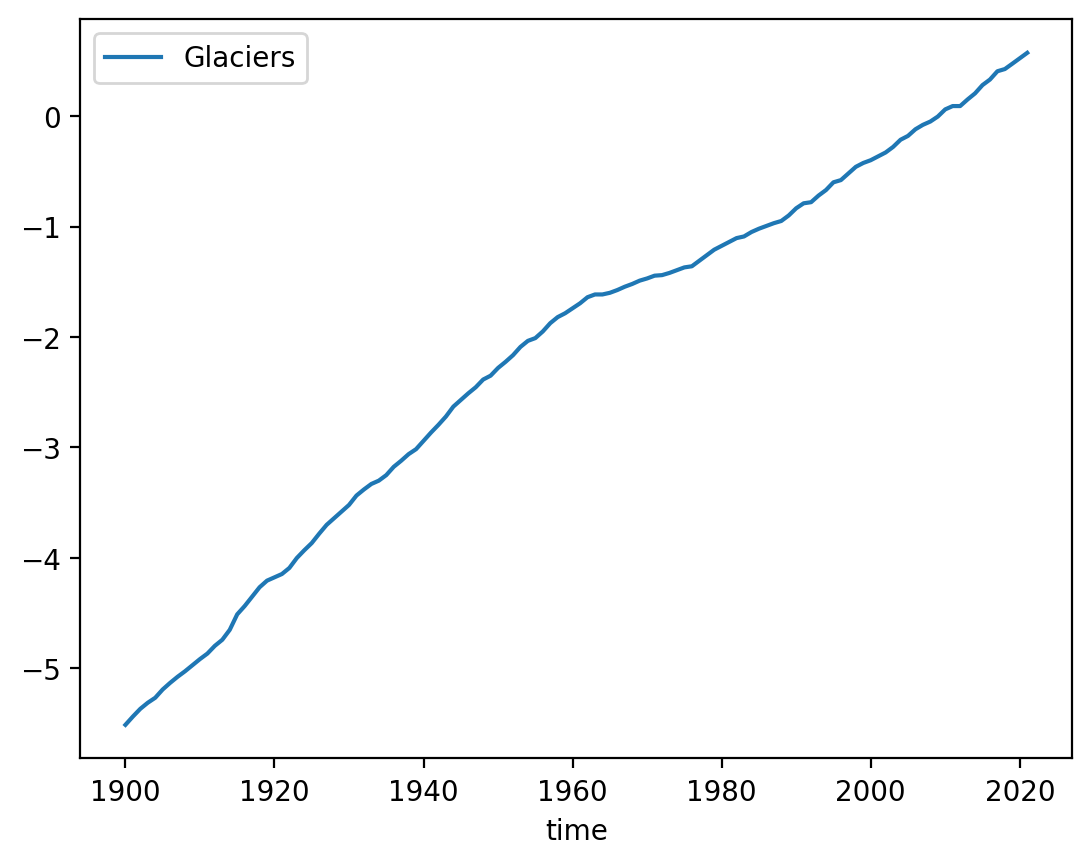

In [86]:
glac_ts_df.plot()

In [ ]:
wpn_ef_df = make_wpn_ef([22], diff_sl_df, False, 
                        with_trend=False, product=opt_wind_ibe[1])